# Granular phase function

## Overview

This tutorial showcases a more practical application and is a great introduction to write efficient integrator-like rendering code with the Mitsuba library.

In volumetric rendering, the *phase function* describes the angular distribution of light scattering when interacting with a particle in the medium. Have you ever wondered how a participating medium would look like if every particle had the shape of a bunny, or was made of frosty glass? ❄️🐰 For this you would need to know the phase function of such a medium, and this is what we are going to compute in this tutorial.

The following code is inspired from this [paper][1], where the authors manage to efficiently render granular materials, like sand, snow or sugar.

At a very high-level, here are the key stages of the algorithm we are going to use in this tutorial:

- Represent a single particle with a shape and a BSDF
- Generate rays coming from random directions around the particle object
- Compute bounces of the light path inside the particle until they escape
- Once escaped, record the out-going direction in the local frame of the original direction into a histogram

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Work with cartesian coordinate systems and coordinate frame objects</li>
  <li>Use a sampler to generate random numbers</li>
  <li>Write a custom integrator-like script</li>
  <li>Use scatter reduction drjit routine to accumulate values into a histogram</li>
</ul>

</div>

[1]: https://cs.dartmouth.edu/wjarosz/publications/meng15granular.html

## Setup

As always, we start by importing the libraries and setting the variant.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Initializating the scene 

To keep this tutorial simple, we are only going to compute the phase function of a dielectric sphere. Although only minor changes would be necessary to allow the use of other shapes and materials in this script (e.g., a frosty glass bunny ❄️🐰).

On top of various mesh loaders (e.g., `ply`, `obj`, ...), Mitsuba supports several analytical shapes (e.g., `Sphere`, `Rectangle`, ...), that can be very handy when writing prototype applications.

As done previously in other tutorials, we are going to use the [<code>load_dict()</code>][1] routine to instanciate a scene containing a sphere and a dielectric BSDF.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict

In [2]:
scene = mi.load_dict({
    'type' : 'scene',
    'grain' : {
        'type' : 'sphere',
    }
})

bsdf = mi.load_dict({
    'type' : 'dielectric',
    'int_ior' : 'water', # We can also use float values
    'ext_ior' : 'air',
})

Performing Monte-Carlo integration requires the ability to generate random numbers. Mitsuba comes with a set of [<code>Sampler</code>][1] classes that can be used to do exactly that. For simplicity, in this application, we are going to use the most basic sampler, [<code>independent</code>][2], which we can instanciate with the [<code>load_dict()</code>][3] routine.

In order to write vectorized code, we need to choose a *wavefront* size, corresponding to the number of light paths we are going to compute simultaneously. The `sampler` instance needs to be aware of the wavefront size so to produce random arrays of the right size. This can be done using the [<code>Sampler.seed()</code>][4] method at the same time as choosing a seed for our random number generator (here `0`).

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_samplers.html#independent-sampler-independent
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.load_dict
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler.seed

In [3]:
sampler = mi.load_dict({'type' : 'independent'})
sampler.seed(0, wavefront_size=int(1e7))

## Generating primary rays

In the following cell, we are going to generate our primary rays, coming from all directions towards the center of the scene. For this, we use the sampler instance to generate random ray directions and offsets for the ray origins. The `Sampler` class only implements methods for producing 1D/2D uniformly distributed points in the unit interval/square. Fortunately, Mitsuba provides a whole set of warping techniques that map from the unit square to other domains such as spheres, hemispheres, etc. Here we leverage the `warp.square_to_uniform_sphere()` routine to generate a set of random ray directions from the 2D unit points given using [<code>Sampler.next_2d()</code>][1].

We then construct a coordinate frame [<code>Frame3f</code>][2] around the sampled ray directions which we will use to convert between local and world coordinate spaces.

We sample ray origin positions by first computing 2D offsets in $[-1, 1]^2$ using the sampler instance. We can then easily compute 3D positions in local coordinates, where we offset the z-component by `-1` as the z-axis represents the forward ray direction. Using the coordinate frame object, we convert the ray origin positions from local to world coordinate space.

The [<code>Scene</code>][3] class exposes a [<code>bbox()</code>][4] method that can be used to retrieve the bounding box of the entire scene. We then convert it to a bounding sphere and use it to move the ray origin accordingly so to make sure our set of rays covers the entire scene domain.

Finally, we create primary rays of type [<code>Ray3f</code>][5], setting the desired wavelength for our simulation.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler.next_2d
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Scene
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Scene.bbox
[5]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Ray3f

In [4]:
# Sample ray directions
d = mi.warp.square_to_uniform_sphere(sampler.next_2d())

# Construct coordinate frame object
frame = mi.Frame3f(d)

# Sample ray origins
xy_local = 2.0 * sampler.next_2d() - 1.0
local_o = mi.Vector3f(xy_local.x, xy_local.y, -1.0)
world_o = frame.to_world(local_o)

# Move ray origin according to scene bounding sphere
bsphere = scene.bbox().bounding_sphere()
o = world_o * bsphere.radius + bsphere.center

# Construct rays
rays = mi.Ray3f(o, d)

## Intra-grain transport

Let's now use those rays to construct light paths bouncing many times inside of the particle object.

For this, we perform a first ray intersection query with the scene using [<code>Scene.ray_intersect()</code>][1] which will return a [<code>SurfaceInteraction3f</code>][2] object, containing the surface interaction information. We use [<code>is_valid()</code>][2] to find the rays that actually interact with the object.

After initializing the `throughput` and `active` variables, we perform a symbolic loop to compute the different bounces of the light paths. At every iteration of the loop. we compute the following:

- Sample new directions from the BSDF using the sampler instance and the current surface interaction
- Update the throughput and rays for the next bounce using the [<code>SurfaceInteraction3f.spawn_ray()</code>][3] method
- Trace the new set of rays to find the next intersection with the object
- Evaluate the kernels to make sure the JIT compiler doesn't accumulate instructions of all loop iterations

We wrap this computation in the Python function <code>sample</code>, where the Dr.Jit decorator [<code>@dr.syntax</code>][4] provides the syntactic sugar that allows us to express the symbolic control flow statements [<code>dr.while_loop</code>][5] and [<code>dr.if_stmt</code>][6] within the function as standard Python <code>while</code> and <code>if</code> statements respectively.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Scene.ray_intersect
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f.spawn_ray
[4]: https://drjit.readthedocs.io/en/latest/cflow.html#control-flow
[5]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.while_loop
[6]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.if_stmt

In [5]:
@dr.syntax 
def sample(rays: mi.Ray3f, sampler: mi.Sampler):

    # Find first ray intersection with the object
    si = scene.ray_intersect(rays)
    valid = si.is_valid()

    # Maximum number of bounces
    max_bounces = 10

    # Loop state variables
    throughput = mi.Spectrum(1.0)
    active = mi.Bool(valid)
    i = mi.UInt32(0)
    
    while active & (i < max_bounces):
        # Sample new direction
        ctx = mi.BSDFContext()
        bs, bsdf_val = bsdf.sample(ctx, si, sampler.next_1d(), sampler.next_2d(), active)

        # Update throughput and rays for next bounce
        throughput[active] *= bsdf_val
        rays[active] = si.spawn_ray(si.to_world(bs.wo))

        # Find next intersection
        si = scene.ray_intersect(rays, active)
        active &= si.is_valid()
    
        # Increase loop iteration counter
        i += 1

    # Only account for rays that have escaped
    valid &= ~active
        
    # We don't care about a specific color for this tutorial
    return rays, mi.luminance(throughput), valid
    
rays, throughput, valid = sample(rays, sampler)

## Calculating the histogram

We are only interested in the light paths that have escaped the object, hence we first need to update the `valid` array mask.

The escaping directions are given by the final ray direction, which we convert to local coordinates using the previously built `frame` object. It is then straighforward to compute the `theta` angle in spherical coordinates and the corresponding bin index in the histrogram.

Here it is important to account for the distortion introduced in the projection to spherical coordinates, hence we divide the throughput variable with the projection jacobian.

The histogram array is initialized using `dr.zero` and we accumulate the computed values into their corresponding bins using the `dr.scatter_reduce(dr.ReduceOp.Add, ...)` routine.

In [6]:
# Resolution of the histogram
histogram_size = 512

# Convert escaping directions into histogram bin indices
cos_theta = mi.Frame3f.cos_theta(frame.to_local(rays.d))
theta = dr.acos(cos_theta)
theta_idx = mi.UInt32(theta / dr.pi * histogram_size)

# Account for projection jacobian
throughput *= 1.0 / dr.sqrt(1 - cos_theta**2)

# Accumulate values into the histogram
histogram = dr.zeros(mi.Float, histogram_size)
dr.scatter_reduce(dr.ReduceOp.Add, histogram, throughput, theta_idx, valid)

# Execute the kernel by evaluating the histogram
dr.eval(histogram);

## Plotting the histogram

Let's now take a look at the resulting angular distribution! We plot it in log scale on a regular plot as well as a polar plot.

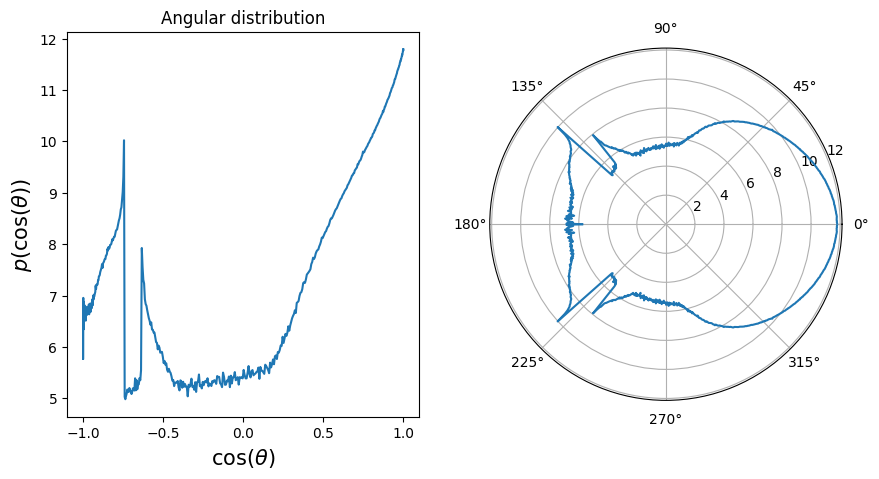

In [7]:
from matplotlib import pyplot as plt
import numpy as np

x = dr.linspace(mi.Float, 0, dr.pi, len(histogram), endpoint=True)
histogram_log = np.array(dr.log(histogram))

fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(121, title='Angular distribution') 
ax.plot(np.array(dr.cos(x)), histogram_log, color='C0')
ax.set_xlabel(r'$\cos(\theta)$', size=15)
ax.set_ylabel(r'$p(\cos(\theta))$', size=15)

ax = fig.add_subplot(122, polar=True, title='polar plot') 
ax.plot(np.array(x), histogram_log, color='C0')
ax.plot(np.array(-x), histogram_log, color='C0', label='test');

## See also

- [The <code>independent</code> sampler][1]
- [<code>mitsuba.warp.square_to_uniform_sphere()</code>][2]
- [<code>mitsuba.Ray3f</code>][3]

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_samplers.html#independent-sampler-independent
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.warp.sqaure_to_uniform_sphere
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Ray3f